# Finding Related Tags on Data Science Stack Exchange
Using a sample of questions and their tags, we want to find out which tags are related via the proxy of being used together on a given question. For computational simplicity we limit our simultaneous tags to pairs only. 

This is an extension / alternative project that uses the same sample dataset as a *DataQuest* guided project. The data was pulled from the data science [Stack Exchange](https://datascience.stackexchange.com) database via SQL.

## Preparing the Data
First we will import the relevant modules and set up the initial dataframe with the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Read in the data
df = pd.read_csv("questions.csv")

# Drop unwanted column
df.drop("FavoriteCount", axis=1, inplace=True)

# Check for null values
df.isnull().sum()

Id              0
CreationDate    0
Score           0
ViewCount       0
Tags            0
AnswerCount     0
dtype: int64

In [3]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0


It appears that the data is in good shape already, so the only thing left is to fix any stray data types.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            8839 non-null   int64 
 1   CreationDate  8839 non-null   object
 2   Score         8839 non-null   int64 
 3   ViewCount     8839 non-null   int64 
 4   Tags          8839 non-null   object
 5   AnswerCount   8839 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 414.5+ KB


In [5]:
# Fix the date data type
df["CreationDate"] = pd.to_datetime(df.CreationDate)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            8839 non-null   int64         
 1   CreationDate  8839 non-null   datetime64[ns]
 2   Score         8839 non-null   int64         
 3   ViewCount     8839 non-null   int64         
 4   Tags          8839 non-null   object        
 5   AnswerCount   8839 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 414.5+ KB


## Formatting Tags

We now have a dataframe with all the columns we need, and have performed some additional cleaning in case we want to use the other columns later on.

The first problem to solve is the tags column. Currently it is not very easy to extract the information we want directly, so we will separate the tags into the equivalent of dummy columns. Note we cannot use the pandas method directly to make this easy, since there are a varied number of tags in each entry. 

The method we will use is to create a set of the unique tags for later use, then use sklearn's *MultiLabelBinarizer()* to create our dummies since it can handle the multi-labelled entries.

In [6]:
# Convert each Tags entry to a list for easier processing
df["Tags"] = df.Tags.str[1:-1].str.split("><")

In [7]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0


In [8]:
# Collect all of the unique tags into a set for potential later use

unique_tags = set()
for tags in df.Tags:
    for tag in tags:
        unique_tags.add(tag)
len(unique_tags)

526

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

# Create the Tag dummy columns
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(mlb.fit_transform(df["Tags"]), columns=mlb.classes_)
dummies.index = df.index
df = pd.concat([df, dummies], axis=1)

df.shape

(8839, 532)

## Collecting the Pairs

We now have our dummy columns for each individual tag occurence. Our aim is to investigate the relationship between tags though, so we need to do some more work on our data as the next step.

We ideally want a paired dummy column for each possibe pair of tags occuring in the same question. Fortunately, this is achievable directly with *PolynomialFeatures()* from scikit-learn. We use this with the correct parameters and cleanup to add every possible pairing to our dataframe as a dummy column.

In [10]:
# Discard the original Tags column as it is no longer needed
df.drop("Tags", inplace=True, axis=1)
df.head()

,Id,CreationDate,Score,ViewCount,AnswerCount,.net,3d-object-detection,3d-reconstruction,ab-test,accuracy,...,weighted-data,weka,wikipedia,wolfram-language,word,word-embeddings,word2vec,xboost,xgboost,yolo
0,44419,2019-01-23 09:21:13,1,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44420,2019-01-23 09:34:01,0,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,44423,2019-01-23 09:58:41,2,1651,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44427,2019-01-23 10:57:09,0,55,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44428,2019-01-23 11:02:15,0,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from sklearn.preprocessing import PolynomialFeatures

# Add columns indicating the presence of a specific pair of tags
poly = PolynomialFeatures(2, include_bias=False, interaction_only=True)
ints = poly.fit_transform(df.iloc[:, 5:])
cols = poly.get_feature_names_out()

In [12]:
int_df = pd.DataFrame(ints, columns=cols)
int_df.head()

,.net,3d-object-detection,3d-reconstruction,ab-test,accuracy,activation,activation-function,active-learning,activity-recognition,actor-critic,...,word-embeddings word2vec,word-embeddings xboost,word-embeddings xgboost,word-embeddings yolo,word2vec xboost,word2vec xgboost,word2vec yolo,xboost xgboost,xboost yolo,xgboost yolo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


That's a lot of columns. We now have a dummy column for every possible pairing of tags and have removed the other columns for now to make the rest of our analysis simpler. 

## Getting the Frequencies

We only need the total frequency of each pairing from this point, so we convert our massive dataframe into a series as well via a sum. The output of the previous function kept our individual tags as columns which we no longer need. We will remove these, and also filter the resulting series to remove any pairings of tags that don't actually occur in the sample. 

In [13]:
# Sum the columns (tag pairings)
sums = int_df.sum()
sums.index = cols

# Remove pairings that have no actual occurences in the sample
reduced_sums = sums[sums > 0]
reduced_sums.value_counts()

1.0       4565
2.0       1261
3.0        652
4.0        357
5.0        251
          ... 
493.0        1
1055.0       1
77.0         1
224.0        1
105.0        1
Length: 160, dtype: int64

In [14]:
# Drop the individual tag columns since we only care about pairings now
int_sums = reduced_sums.drop(list(unique_tags))

We want to create a final dataframe that contains a row for each pair of tags, listing the total number of occurences together as well as separately. The first step is to create a series of frequencies for the individual tags, and convert our paired tags series to a dataframe ready for more data.

In [15]:
# Collect the total occurences of every individual tag using the original dataframe
tag_counts = df.iloc[:, 5:].sum()
tag_counts.index = df.iloc[:, 5:].columns
tag_counts[:10]

.net                     1
3d-object-detection      1
3d-reconstruction        9
ab-test                  6
accuracy                89
activation               1
activation-function     44
active-learning          4
activity-recognition     5
actor-critic            21
dtype: int64

In [16]:
# Prepare the final dataframe by first adding the pair counts from earlier
final = pd.DataFrame()
final["Questions_with_both"] = int_sums
final.index = int_sums.index
final.head()

,Questions_with_both
.net machine-learning,1.0
3d-object-detection computer-vision,1.0
3d-object-detection deep-learning,1.0
3d-object-detection kitti-dataset,1.0
3d-reconstruction cloud,1.0


## Combining The Data

Now we want to add the individual tags as columns to our dataframe for clarity and future analysis. The pairs currently exist in the index and are separated by a space, which makes it easy to extract the individual tags.

In [17]:
# Extract the individual tags from the index
final["Tag_1"] = final.index.map(lambda x: x.split()[0])
final["Tag_2"] = final.index.map(lambda x: x.split()[1])
final

,Questions_with_both,Tag_1,Tag_2
.net machine-learning,1.0,.net,machine-learning
3d-object-detection computer-vision,1.0,3d-object-detection,computer-vision
3d-object-detection deep-learning,1.0,3d-object-detection,deep-learning
3d-object-detection kitti-dataset,1.0,3d-object-detection,kitti-dataset
3d-reconstruction cloud,1.0,3d-reconstruction,cloud
...,...,...,...
visualization wolfram-language,2.0,visualization,wolfram-language
visualization word2vec,1.0,visualization,word2vec
weighted-data xgboost,2.0,weighted-data,xgboost
word word-embeddings,1.0,word,word-embeddings


Similarly we now want to add the individual tag frequencies to the dataframe. We need to give our series of tag frequencies a name before we are allowed to use it in a merge. We merge twice, joining on each tag to get the correct counts.

In [18]:
# Name the tag counts data
tag_counts.name = "Tag_counts"

# Merge to create two new columns of tag counts for each pair
final = final.merge(tag_counts, left_on="Tag_1", right_index=True)
final = final.merge(tag_counts, left_on="Tag_2", right_index=True)
final

,Questions_with_both,Tag_1,Tag_2,Tag_counts_x,Tag_counts_y
.net machine-learning,1.0,.net,machine-learning,1,2693
3d-reconstruction machine-learning,4.0,3d-reconstruction,machine-learning,9,2693
accuracy machine-learning,29.0,accuracy,machine-learning,89,2693
activation-function machine-learning,10.0,activation-function,machine-learning,44,2693
active-learning machine-learning,4.0,active-learning,machine-learning,4,2693
...,...,...,...,...,...
nlp stemming,1.0,nlp,stemming,493,2
nltk stemming,1.0,nltk,stemming,43,2
python spyder,1.0,python,spyder,1814,1
pytorch pytorch-geometric,1.0,pytorch,pytorch-geometric,175,2


In [19]:
# Rename the final columns
final.columns = ["Questions_with_both", "Tag_1", "Tag_2", "Tag_1_Count", "Tag_2_Count"]

# Fix the column type
final["Questions_with_both"] = final.Questions_with_both.astype("int")

# Sort by number of questions for each pairing
final.sort_values("Questions_with_both", ascending=False).head(25)

,Questions_with_both,Tag_1,Tag_2,Tag_1_Count,Tag_2_Count
machine-learning python,499,machine-learning,python,2693,1814
deep-learning machine-learning,429,deep-learning,machine-learning,1220,2693
machine-learning neural-network,366,machine-learning,neural-network,2693,1055
deep-learning neural-network,305,deep-learning,neural-network,1220,1055
keras python,280,keras,python,935,1814
classification machine-learning,259,classification,machine-learning,685,2693
keras tensorflow,256,keras,tensorflow,935,584
deep-learning keras,247,deep-learning,keras,1220,935
pandas python,244,pandas,python,354,1814
keras neural-network,235,keras,neural-network,935,1055


## Investigating Tag Relationships

After some cleaning of column names and data types, we have a reasonable final dataframe that we can use for our analysis. From here we have some options. We could sort by the *Questions_with_both* column as above, and find out which pairs are most commonly used together, but this is heavily biased towards tags that are both popular individually. While this isn't a terrible metric, we can try and create a new one that measures how often tags are used together in a more normalised way. 

We will consider the following idea: 
- Find the minimum frequency of the two involved tags.
- Divide the *Questions_with_both* value by this number to get the proportion of tag uses that involve a specific pair.
- Multiply by 100 because it looks nicer.

A motivation for this is the example of niche topics. Consider a fairly rare tag that isn't used very often: In the original metric, we would rate any pairing of this tag with another incredibly low, as the absolute number of questions the pair appears in is capped by the unpopular tag's frequency. Instead, we use the tag's low frequency as the denominator and compute the % of questions that a given pairing appeared in. This way an unpopular tag can still score highly on interaction with another tag despite its low usage rate. 

In [20]:
def int_scorer(row):
    count = np.min([row["Tag_1_Count"], row["Tag_2_Count"]])
    score = 100 * row["Questions_with_both"] / count
    return round(score, 2)

# Add the new column 
final["Interaction_score"] = final.apply(int_scorer, axis=1)
final.sort_values("Interaction_score", ascending=False).head(25)

,Questions_with_both,Tag_1,Tag_2,Tag_1_Count,Tag_2_Count,Interaction_score
.net machine-learning,1,.net,machine-learning,1,2693,100.0
dplyr r,6,dplyr,r,6,268,100.0
exploitation reinforcement-learning,1,exploitation,reinforcement-learning,1,203,100.0
dynamic-programming reinforcement-learning,3,dynamic-programming,reinforcement-learning,3,203,100.0
discounted-reward reinforcement-learning,5,discounted-reward,reinforcement-learning,5,203,100.0
cs231n gradient-descent,1,cs231n,gradient-descent,1,98,100.0
cause-effect-relations data-mining,1,cause-effect-relations,data-mining,1,217,100.0
neural-network rdkit,1,neural-network,rdkit,1055,1,100.0
anaconda rdkit,1,anaconda,rdkit,20,1,100.0
activation rdkit,1,activation,rdkit,1,1,100.0


Looking at the results, we now have a lot of unpopular tags with high interaction scores. Unfortunately this isn't a good metric either, as it naturally punishes popular tags and those that have lots of possible distinct pairings. For a broad topic like python, there are plenty of tags that are related and hence the score for each pairing is never going to approach 100 regardless of how intertwined the topics are. 

In addition, including pairings with a small number of occurences can be problematic. It is possible that the user posting a question isn't familiar with the correct tags to use, resulting in incorrect pairings in some cases. For popular tags, these mistakes shouldn't be too influential but for others we could end up with an interaction score of 100 for a nonsensical pairing of tags. 

A compromise is to filter results to a minimum number of questions that a pair appeared in. This should help reduce the noise but goes against the new metric's aim to allow unpopular tags a chance. This should still be an improvement over the previous metric.

In [21]:
# Filter and sort the data based on the new criteria
final_filtered = final[final.Questions_with_both > 20]
final_filtered.sort_values("Interaction_score", ascending=False).head(25)

,Questions_with_both,Tag_1,Tag_2,Tag_1_Count,Tag_2_Count,Interaction_score
dqn reinforcement-learning,34,dqn,reinforcement-learning,36,203,94.44
q-learning reinforcement-learning,33,q-learning,reinforcement-learning,37,203,89.19
policy-gradients reinforcement-learning,24,policy-gradients,reinforcement-learning,27,203,88.89
deep-learning deep-network,22,deep-learning,deep-network,1220,29,75.86
dataframe pandas,60,dataframe,pandas,81,354,74.07
forecast time-series,25,forecast,time-series,34,466,73.53
forecasting time-series,59,forecasting,time-series,85,466,69.41
pandas python,244,pandas,python,354,1814,68.93
dataframe python,51,dataframe,python,81,1814,62.96
nlp nltk,27,nlp,nltk,493,43,62.79


These results are a little more varied in terms of tag popularity, but it still focuses mostly on less popular tags.

Let's try combining the popularity of a tag with the current definition of interaction score. We take the average of two different metrics to get a final score, and filter out the very low frequency tags since they still dominate the top 25 under this new metric.

In [22]:
def int_scorer(row):
    count = np.min([row["Tag_1_Count"], row["Tag_2_Count"]])
    int_score = 100 * row["Questions_with_both"] / count
    pop_score = 100 * row["Questions_with_both"] / final.Questions_with_both.max()
    score = np.mean([int_score, pop_score])
    return round(score, 2)

# Generate the new scores
final["Interaction_score"] = final.apply(int_scorer, axis=1)

# Filter and sort the results
final_filtered = final[final.Questions_with_both > 10]
final_filtered.sort_values("Interaction_score", ascending=False).head(25)

,Questions_with_both,Tag_1,Tag_2,Tag_1_Count,Tag_2_Count,Interaction_score
machine-learning python,499,machine-learning,python,2693,1814,63.75
deep-learning machine-learning,429,deep-learning,machine-learning,1220,2693,60.57
pandas python,244,pandas,python,354,1814,58.91
machine-learning neural-network,366,machine-learning,neural-network,2693,1055,54.02
dqn reinforcement-learning,34,dqn,reinforcement-learning,36,203,50.63
orange orange3,19,orange,orange3,64,20,49.40
q-learning reinforcement-learning,33,q-learning,reinforcement-learning,37,203,47.90
keras tensorflow,256,keras,tensorflow,935,584,47.57
policy-gradients reinforcement-learning,24,policy-gradients,reinforcement-learning,27,203,46.85
python scikit-learn,235,python,scikit-learn,1814,540,45.31


These results look a lot fairer in terms of tag popularity. While not all tags are self-explanatory, pretty much all of the top 25 pairs look quite related under this new metric. It's unlikely we can create a perfect absolute ordering of tag relations, but this looks good enough to quickly find some strong relationships.

This is where we will leave things for now in terms of metric choices. 

## Visualising Tag Relationships

From here we want to be able to quickly create visualisations of the top N related tags for any given tag. This could be useful to quickly sample a bunch of related topics for an unknown tag. We also want to be able to change the filtering strength, since we may need to include unpopular tags when investigating other rare tags.

We begin by setting up the seaborn style that we want to use. The next issue is yet again related to the format of tags in our dataframe. Each tag can appear in either of the individual tag columns on each row, stopping us from plotting a single column directly against *Interaction_score*. We can run a quick function through the data to swap all instances of a particular tag into the same column. 

Along with this formatting we can do some filtering based on the number of related tags that we want, and the strength of the popularity filtering. After all of this we get a nice and easy dataframe to plot with seaborn to wrap things up.

In [23]:
# Set the style and colour scheme
sns.set_style("darkgrid")
sns.set_palette("Paired")

In [26]:
# Function to ensure a given tag is in Tag_1 column for each row
def tag_switch(row, tag_):
    if row["Tag_2"] == tag_:
        row["Tag_2"] = row["Tag_1"]
        row["Tag_1"] = tag_
    return row

# Plot the best pairings for a particular tag with given filters
def plot_relations(df, tag, filter_strength=10, num=10):
    
    # Replace any spaces with dashes to match the format of the data, allowing simpler function use
    given_tag = tag
    tag = tag.replace(" ", "-")
    
    # Check that the tag actually exists in the data
    unique_tags = set(df["Tag_1"].unique()).union(set(df["Tag_2"].unique()))
    if tag not in unique_tags:
        print(f"{given_tag} not found in data.")
        return
    
    # Apply filtering to the data to remove low-frequency pairs
    df = df[df.Questions_with_both > filter_strength]
    df = df[(df["Tag_1"]==tag)|(df["Tag_2"]==tag)].sort_values("Interaction_score", ascending=False)
    
    # Restrict the results to the requested or default number
    num = min(num, len(df))
    if num == 0:
        print(f"{given_tag} not found in filtered data, try a weaker filter.")
        return
    
    # Re-organise the tag columns to allow easier plotting for this tag
    df = df.apply(tag_switch, args=(tag,), axis=1)
    
    # Plot and label the results
    g = sns.catplot(kind="bar", x="Interaction_score", y="Tag_2", data=df.head(num))
    g.set(ylabel="", xlabel="Strength of Relationship")
    g.fig.suptitle(f"Top {num} closely related question tags to $\it{given_tag}$")
    g.tight_layout()
  
    

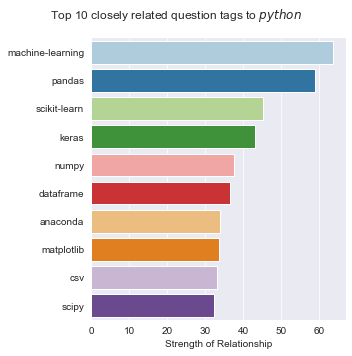

In [25]:
# Example use of the plotting function
plot_relations(final, "python")

## Conclusion
 
Looks good! We can now use this function to find some closely related tags for any tag that exists in the sampled data. We could perform some additional plot formatting to improve the look, but this is better to do case by case since the plots can be so different. 

Could also consider using some sort of regex or string similarity to allow easier entry of tags in the final plotting function, rather than requiring a perfect match which may be based on a certain standard set by Stack Exchange that isn't universal.